# Geolocation Analysis of Transactions

Goal: Analyze spatial patterns of fraud transactions, detect randomness, and engineer usefull location features

In [28]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from scipy.special.cython_special import huber

from mastercard.config import PROCESSED_DATA_DIR


2025-06-07 11:49:06.917 | INFO     | mastercard.config:<module>:11 - PROJ_ROOT path is: /home/marcin/workspace/data_sience/mastercard


In [29]:
PROCESSED_DATA_DIR = Path("../data/processed")
FIGURES_DIR = Path("../reports/figures")



In [3]:
df = pd.read_parquet(PROCESSED_DATA_DIR / "transactions.parquet")


In [4]:
df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,"{'lat': 40.057938, 'long': 14.959737}",debit_card,1,145,0,0
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,online,EUR,Android,"{'lat': 42.05935, 'long': 1.596625}",debit_card,1,32,1,0
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,online,EUR,Android,"{'lat': 50.923432, 'long': 21.795262}",credit_card,1,604,1,0
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,"{'lat': 56.833396, 'long': -9.881566}",credit_card,0,1031,1,0
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,"{'lat': 54.042996, 'long': 2.168516}",credit_card,1,330,0,0


In [6]:
df_location =  pd.json_normalize(df['location'])

In [7]:
df_location.head()

,lat,long
0,40.057938,14.959737
1,42.059350,1.596625
2,50.923432,21.795262
3,56.833396,-9.881566
4,54.042996,2.168516


In [8]:
df = pd.concat([df.drop(columns=['location']), df_location], axis=1)

In [9]:
df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud,lat,long
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,debit_card,1,145,0,0,40.057938,14.959737
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,online,EUR,Android,debit_card,1,32,1,0,42.059350,1.596625
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,online,EUR,Android,credit_card,1,604,1,0,50.923432,21.795262
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,credit_card,0,1031,1,0,56.833396,-9.881566
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,credit_card,1,330,0,0,54.042996,2.168516


In [12]:
# walidacja skrajnych wartości
print("Latitude range: ", df['lat'].min(), df['lat'].max())
print("Longitude rang: ", df["long"].min(), df["long"].max())

Latitude range:  35.000013 69.999823
Longitude rang:  -9.999975 39.999761


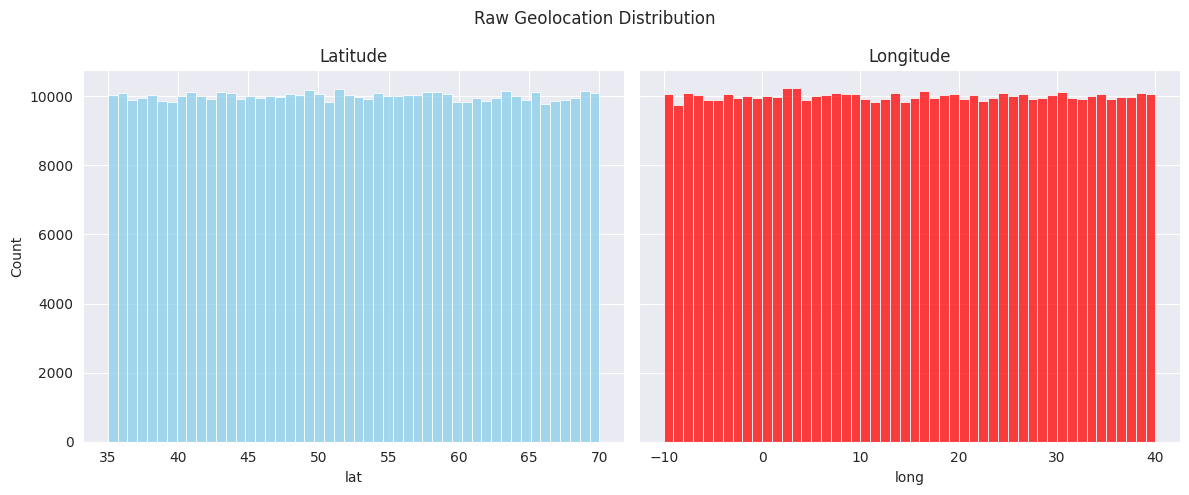

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(df["lat"],bins=50, ax=ax[0], color="skyblue")
ax[0].set_title("Latitude")

sns.histplot(df["long"],bins=50, ax=ax[1], color="red")
ax[1].set_title("Longitude")

plt.suptitle("Raw Geolocation Distribution")

fig.tight_layout()
plt.show()

In [32]:
label_map = {0: "Legitimate", 1: "Fraudulent"}
df_sampled = df.sample(10000, random_state=42).copy()
df_sampled["fraud_label"] = df_sampled["is_fraud"].map(label_map)

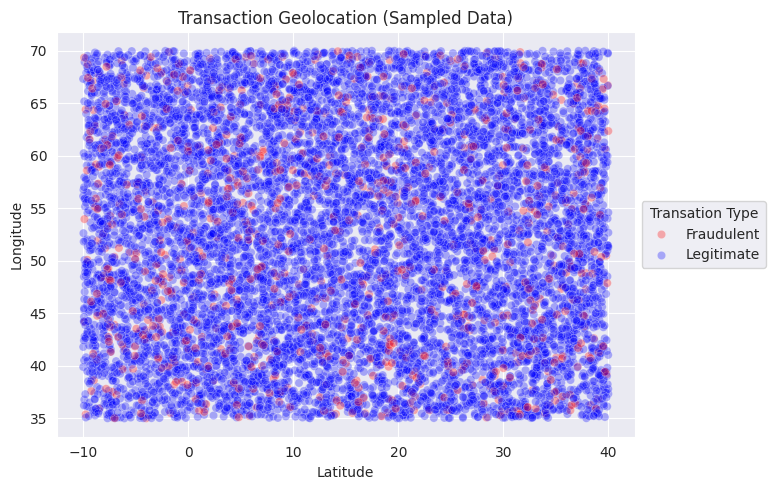

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.scatterplot(
    data=df_sampled,
    ax=ax,
    x="long",
    y="lat",
    hue="fraud_label",
    alpha=0.3,
    palette={"Legitimate": "blue", "Fraudulent": "red"},
)
ax.set(xlabel="Latitude", ylabel="Longitude", title="Transaction Geolocation (Sampled Data)")
ax.set_aspect("equal")

ax.legend(title="Transation Type", loc="center left", bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.savefig(FIGURES_DIR / "transaction_locations_sampled.png")
plt.show()

In [37]:
fig = px.scatter_map(
    df_sampled.sample(5000, random_state=42),
    lat="lat",
    lon="long",
    color="fraud_label",
    hover_data=["is_fraud"],
    zoom=3,
    height=650,
    color_discrete_map={"Legitimate": "rgba(0, 0, 255, 0.3)", "Fraudulent": "red"},
)
# Zapisz do png nie działa na ARM Silicon, zapisz jako www i z www pobierz jako png

fig.write_html(FIGURES_DIR / "transaction_locations_sampled_map.html"
                             "")
fig.show()